# Project Introduction

# Import Required Modules and Data

We will use a fairly standard set of machine learning libraries in our analysis including:

* numpy
* pandas
* matplotlib
* seaborn
* sklearn

In [196]:
import os
from warnings import filterwarnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="Using a non-tuple sequence for multidimensional indexing is deprecated")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

Next we load the raw data downloaded from Kaggle

In [197]:
os.chdir('../data/')
raw = pd.read_csv('kickstarter.csv', parse_dates=[5, 7])

# Data Cleaning

To begin, let's familiarize ourselves with the dataset

In [198]:
raw.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


 First, we notice that there are two columns for the amount of money pledged: `usd pledged` and `usd_pledged_real`. According to documentation for the dataset, the former was converted by Kickstarter and the later by the fixer.io API. Looking at rows 1, 41, 43, and others we can see that the amount in `pledged` does not match `usd pledged` even though the currency for the project is USD. Therefore, `usd_pledged_real` is the more reliable column to use.

We will also drop the project ID since that is a random number which should have no correlation to the project's success. Lastly, the `goal` column is reported in original currency. Since we are converting all amounts to USD for consistency, this is not necessary.

In [199]:
clean = raw.drop(columns=['usd pledged', 'ID', 'goal'])
clean.rename(columns={'usd_pledged_real':'pledged_usd', 'usd_goal_real':'goal_usd'}, inplace=True)

Next, let's look at our target variable `state` and see how it is distributed. The majority of projects are either failed of successful. Canceled is the next biggest category.

In [200]:
clean.groupby('state').size().sort_values(ascending=False)

state
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
dtype: int64

We can simplify this to a binary classification problem with failed or canceled as 0 and successful as 1. Additionally, since we are trying to predict a project's `state` when it launches, any information from the future should be removed.

In [201]:
clean = clean[clean.state.isin(['successful', 'failed', 'canceled'])]
clean.state = clean.state.replace({'successful':1, 'failed':0, 'canceled':0})
clean.drop(columns=['pledged', 'backers', 'pledged_usd'], inplace=True)

It would be interesting to know the duration of each project. First, `launched` needs to be split into its day and time components, and then we can subtract the day component from `deadline`. While we're manipulating `launched`, let's also turn `launch_time` into a numeric format (decimal hours on a 24 hour clock). Checking our work with a quick histogram of `duration`, it is suspicious that there are projects that lasted longer than 14,000 days (over 38 years)!

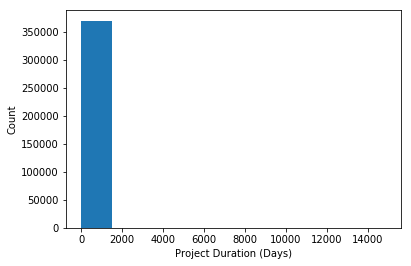

In [202]:
clean['launch_day'] = [d.date() for d in clean.launched]
clean['launch_time'] = [d.time() for d in clean.launched]
clean[['h', 'm', 's']] = clean.launch_time.astype(str).str.split(':', expand=True).astype(float)
clean['launch_time'] = clean.h.values + clean.m.values / 60 + clean.s.values / 3600
clean.drop(columns=['h', 'm', 's'], inplace=True)
clean['duration'] = [(d - l).days for d, l in zip(clean.deadline.dt.date, clean.launch_day)]
clean.drop(columns='launched', inplace=True)

fig = plt.figure()
plt.hist(clean.duration)
plt.xlabel('Project Duration (Days)')
plt.ylabel('Count')
plt.show()

Looking at the year from `launch_time`, there are some projects which supposedly started in 1970. However, Kickstarter didn't even exist back then so these are most likely data entry errors and we will remove them. Making a `launch_year` category and then querying the dataframe is an easy way to accomplish this. When the histogram for duration is re-plotted, it looks much more reasonable.

[1970 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


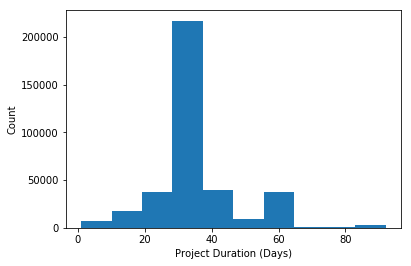

In [203]:
print(np.unique([d.year for d in clean.launch_day]))
clean['launch_year'] = [d.year for d in clean.launch_day]
clean.query('launch_year != 1970', inplace=True)

fig = plt.figure()
plt.hist(clean.duration)
plt.xlabel('Project Duration (Days)')
plt.ylabel('Count')
plt.show()

To make separating our target variable (`state`) from the features, we will move it to the last column. Then the cleaned data is written to a CSV so we don't need to repeat these steps in the future.

In [204]:
cols = list(clean.columns)
cols.append(cols.pop(cols.index('state')))
clean = clean.reindex(columns=cols)
clean.to_csv('kickstarter-clean.csv', index=False)

# Exploratory Data Analysis (EDA)

Let's start by seeing how projects are distributed by category

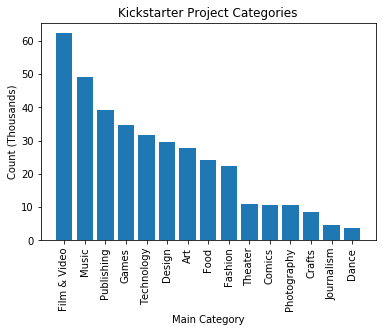

In [205]:
main_categories = clean.groupby('main_category').size().sort_values(ascending=False)
n_main = [i / 1000 for i in list(main_categories)]
labels_main = list(main_categories.index)

ind = np.arange(len(main_categories))
plt.bar(ind, n_main)
plt.ylabel('Count (Thousands)')
plt.xlabel('Main Category')
plt.title('Kickstarter Project Categories')
plt.xticks(ind, labels_main, rotation=90)
plt.show()

How does sucess vary with factors like duration, goal, and time of day the project was launched?

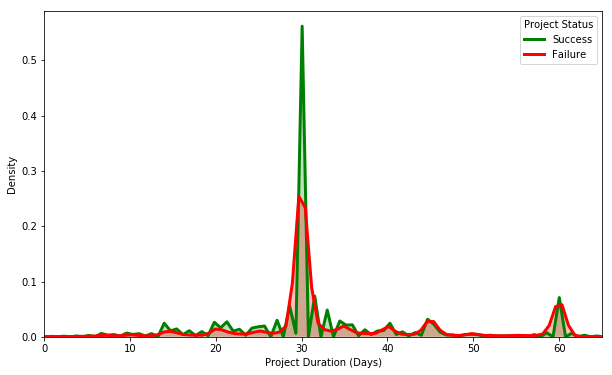

In [206]:
plt.figure(figsize=(10, 6))
sns.distplot(clean.query('state == 1').duration, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Success', color='green')
sns.distplot(clean.query('state == 0').duration, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Duration (Days)')
plt.ylabel('Density')
plt.xlim((0, 65))
plt.show()

The vast majority of projects are 30 days long regardless of their status. The next largest peaks are at 60 and 45 days, indicating that projects tend to be scheduled in terms of months (1, 1.5, 2, etc). There is a slight trend
towards shorter durations leading to an increased chance of success (more 15-25 day project succeeded).

Now we can look at the project funding goal (converted to USD for a fair comparison across all the currencies). Plotting on a log10 scale helps compress the data into a viewable range since goals range from \$0.01 up to over \$166,000,000

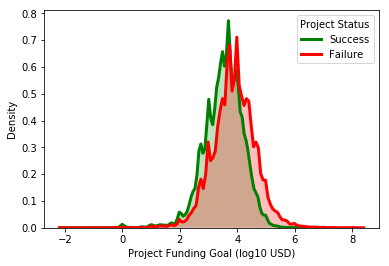

In [207]:
sns.distplot(np.log10(clean.query('state == 1').goal_usd.values), hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3}, label='Success', color='green')
sns.distplot(np.log10(clean.query('state == 0').goal_usd.values), hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3}, label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Funding Goal (log10 USD)')
plt.ylabel('Density')
plt.show()

The distinction between failure and sucess is a more pronounced here than for duration - projects with a larger funding goal failed more often. The most common goals were around \$10k USD.

What about time of day the project was launched? If people are most likely to hear about a project at its inception, it would be critical to launch at a time when people are available (for instance, weekday evenings).

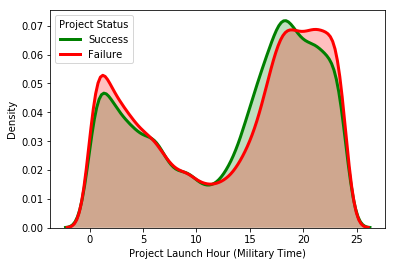

In [208]:
sns.distplot(clean.query('state == 1').launch_time, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Success', color='green')
sns.distplot(clean.query('state == 0').launch_time, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Launch Hour (Military Time)')
plt.ylabel('Density')
plt.show()

Failed projects look like they may launch more often at the extreme start/end of days, but the trend is not super strong. Another angle to explore the data from in the future is using Natural Language Processing (NLP). We could see whether there are words or phrases in the project names that correspond well with the project's success.

# Data Transforms

For modeling purposes, we will need a numeric representation of all the columns containing datetimes (`deadline`, `launch_day`, and `launch_time`) and categorical strings (`name`, `category`, `main_category`, `currency`, and `country`). Let's start with representing the datetime columns numerically. 

As we learned above, there are few projects lasting longer than 60 days, so the year information in `deadline` and `launch_day` should be similar. The remaining month and day information can be encoded as day of year (i.e. 1 to 365). Adding a cosine transform is useful here since it indicates to the model that days 1 and 365 are actually more similar than days 1 and 300. Similarly, we can convert `launch_time` into a decimal hour representation on a 24 hour clock and apply another cosine transform.

In [209]:
modeling = clean
modeling.launch_day = [np.cos(d.timetuple().tm_yday / 365 * 2 * np.pi) for d in clean.launch_day] 
modeling.deadline = [np.cos(d.timetuple().tm_yday / 365 * 2 * np.pi) for d in clean.deadline]
modeling.launch_time = np.cos(clean.launch_time.astype('float') / 24 * 2 * np.pi)

Next we'll deal with the categorical string columns. Until we do further NLP research, the best way to encode the project name will be its length. Other categorical variables can be encoded using the `LabelEncoder()` from `sklearn`. After performing the transforms, we print the column `dtypes` to double check that all variables numerical now.

In [210]:
modeling.name = clean.name.str.len()
modeling.dropna(inplace=True) # Some strings returned NA
categorical = modeling.select_dtypes(include=['object']).columns
modeling[categorical] = modeling[categorical].apply(LabelEncoder().fit_transform)
modeling.dtypes

name             float64
category           int64
main_category      int64
currency           int64
deadline         float64
country            int64
goal_usd         float64
launch_day       float64
launch_time      float64
duration           int64
launch_year        int64
state              int64
dtype: object

Now that all variables are numerical, we can check for any pairs that are highly correlated (i.e. $R > 0.8$) since those will adversely affect modeling. Unsurprisingly, `currency` / `country` and `launch_day` / `deadline` are highly correlated. Since all monetary amounts have already been converted to USD, it makes sense to remove `currency`. Let's keep `launch_day` over `deadline` since it's more closely related to the start of a project. After doing this, we save the `modeling` dataframe to a CSV so these steps won't have to be repeated in the future.

In [212]:
modeling.corr().unstack().sort_values().drop_duplicates()
modeling.drop(columns=['currency', 'deadline'], inplace=True)
modeling.to_csv('kickstarter-modeling.csv', index=False)

# Initial Modeling

# Hyperparameter Tuning

# Ensemble Modeling